# Logistic Regression on basic numerical data

# Relevant Imports

In [2]:
import pandas as pd
import numpy as np

# For splitting data and scaling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns

# For balancing data classes
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Logistic Regression model and evaluation metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, classification_report
from sklearn.feature_selection import RFE



# Load and preprocess data

In [3]:
# Load the dataset
file_path = '../../../dataset_final/Daily_Financial_News/MU/MU_numerical.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(data.head())


         Date   Open  Close   High      Volume
0  2020-06-09  52.65  53.15  53.50  17840800.0
1  2020-06-08  54.50  53.70  54.63  22850600.0
2  2020-06-05  52.65  53.72  54.81  34110700.0
3  2020-06-04  48.86  51.22  51.97  34830800.0
4  2020-06-03  48.04  48.91  49.41  34662100.0


In [4]:
# Check for missing values
print(data.isnull().sum())

# Summary statistics of the dataset
print(data.describe())


Date      0
Open      0
Close     0
High      0
Volume    0
dtype: int64
              Open        Close         High        Volume
count  2299.000000  2299.000000  2299.000000  2.299000e+03
mean     25.678982    25.664428    26.111083  3.139897e+07
std      15.583398    15.573432    15.831196  1.539824e+07
min       4.190000     4.320000     4.510000  4.672900e+06
25%      10.955000    10.895000    11.170000  2.140340e+07
50%      24.300000    24.230000    24.680000  2.795570e+07
75%      38.515000    38.690000    39.400000  3.685695e+07
max      63.700000    62.610000    64.660000  1.539061e+08


In [5]:
# Drop the current index and reset to default integer index
data = data.reset_index(drop=True)

# Sort the DataFrame by the 'Dates' column in ascending order
data = data.sort_values(by='Date', ascending=True)

data.head()

,Date,Open,Close,High,Volume
2298,2011-04-20,10.89,11.39,11.40,52613700.0
2297,2011-04-21,11.47,11.52,11.72,43506100.0
2296,2011-04-25,11.46,11.32,11.48,20447100.0
2295,2011-04-26,11.35,11.60,11.64,27400000.0
2294,2011-04-27,11.60,11.80,11.82,29748500.0


# Define features and target value

In [6]:
# Calculate next-day return
data['Movement'] = ((data['Open'].shift(-1) - data['Close']) / data['Close'])

# Shift Movement to align with current day
data['Movement'] = data['Movement'].shift(1)

# Drop the last row because there's no next day to compare
data = data.dropna(subset=['Movement'])

# Convert Movement into binary (1 for up if Movement > 0, else 0)
data['Movement'] = (data['Movement'] > 0).astype(int)

# Check the distribution of the target variable
print(data['Movement'].value_counts().sort_index())

Movement
0    1020
1    1278
Name: count, dtype: int64


In [7]:
# Calculate daily returns (in percentage)
data['Daily_Return'] = data['Close'].pct_change() * 100

# Choose a rolling window (e.g., 10 days) for volatility
window_size = 5
data['Volatility'] = data['Daily_Return'].rolling(window=window_size).std()

# Drop the initial NaNs from rolling calculation
data = data.dropna(subset=['Volatility'])

In [8]:
# Create lagged features to avoid data leakage
data['Close_lag1'] = data['Close'].shift(1)
data['High_lag1'] = data['High'].shift(1)
data['Volume_lag1'] = data['Volume'].shift(1)
data['Daily_Return_lag1'] = data['Daily_Return'].shift(1)
data['Volatility_lag1'] = data['Volatility'].shift(1)

# Drop rows with NaN values introduced by shifting
data = data.dropna(subset=['Close_lag1', 'High_lag1', 'Volume_lag1', 'Daily_Return_lag1', 'Volatility_lag1'])


In [9]:
data.tail(20)


,Date,Open,Close,High,Volume,Movement,Daily_Return,Volatility,Close_lag1,High_lag1,Volume_lag1,Daily_Return_lag1,Volatility_lag1
19,2020-05-12,48.52,45.68,48.56,26738900.0,1,-5.228216,3.292741,48.20,48.72,17353500.0,-0.103627,1.349995
18,2020-05-13,45.86,43.52,45.88,35117500.0,1,-4.728546,3.801718,45.68,48.56,26738900.0,-5.228216,3.292741
17,2020-05-14,43.06,45.72,45.77,27543500.0,0,5.055147,4.678076,43.52,45.88,35117500.0,-4.728546,3.801718
16,2020-05-15,43.27,44.40,44.77,28803900.0,0,-2.887139,4.217116,45.72,45.77,27543500.0,5.055147,4.678076
15,2020-05-18,45.83,45.91,46.15,20307800.0,1,3.400901,4.777524,44.40,44.77,28803900.0,-2.887139,4.217116
14,2020-05-19,45.77,45.11,46.22,17389500.0,0,-1.742540,4.203838,45.91,46.15,20307800.0,3.400901,4.777524
13,2020-05-20,46.50,46.63,47.04,17876500.0,1,3.369541,3.517465,45.11,46.22,17389500.0,-1.742540,4.203838
12,2020-05-21,46.50,45.22,46.56,17445300.0,0,-3.023804,3.289354,46.63,47.04,17876500.0,3.369541,3.517465
11,2020-05-22,45.15,44.93,45.31,13385400.0,0,-0.641309,2.963934,45.22,46.56,17445300.0,-3.023804,3.289354
10,2020-05-26,46.22,45.79,46.68,24303900.0,1,1.914089,2.627051,44.93,45.31,13385400.0,-0.641309,2.963934


In [10]:
data.columns

Index(['Date', 'Open', 'Close', 'High', 'Volume', 'Movement', 'Daily_Return',
       'Volatility', 'Close_lag1', 'High_lag1', 'Volume_lag1',
       'Daily_Return_lag1', 'Volatility_lag1'],
      dtype='object')

In [11]:
# Correlation Metrics
# Specify the columns of interest for correlation with 'Movement'
columns_of_interest = ['Open', 'Close_lag1', 'High_lag1', 'Volume_lag1', 
                        'Daily_Return_lag1', 'Volatility_lag1']

# Calculate the correlation between 'Movement' and each of the specified columns
correlation_with_movement = data[columns_of_interest + ['Movement']].corr()['Movement']

# Drop the self-correlation of 'Movement'
correlation_with_movement = correlation_with_movement.drop('Movement')

# Display the correlation values
print(correlation_with_movement)


Open                 0.023210
Close_lag1           0.003572
High_lag1            0.003422
Volume_lag1         -0.006236
Daily_Return_lag1   -0.017343
Volatility_lag1     -0.006568
Name: Movement, dtype: float64


In [12]:
# Define features (X) and target (y)
features = ['Open', 'Close_lag1', 'High_lag1', 'Volume_lag1', 'Daily_Return_lag1', 'Volatility_lag1']
X = data[features]
y = data['Movement']

# Inspect the feature set
print(X.head())
print(y.head())


       Open  Close_lag1  High_lag1  Volume_lag1  Daily_Return_lag1  \
2291  11.36       11.31      11.44   36678800.0          -1.394943   
2290  11.19       11.23      11.40   21585500.0          -0.707339   
2289  10.86       10.89      11.22   37000000.0          -3.027605   
2288  10.67       10.73      10.97   29570000.0          -1.469238   
2287  11.10       10.90      11.06   35304000.0           1.584343   

      Volatility_lag1  
2291         2.306145  
2290         2.194295  
2289         1.917838  
2288         0.992006  
2287         1.677184  
2291    1
2290    0
2289    0
2288    0
2287    1
Name: Movement, dtype: int64


# Splitting and scaling the data

In [13]:
# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])  # Ensure correct datetime format
data.set_index('Date', inplace=True)
print(data.index)


DatetimeIndex(['2011-05-02', '2011-05-03', '2011-05-04', '2011-05-05',
               '2011-05-06', '2011-05-09', '2011-05-10', '2011-05-11',
               '2011-05-12', '2011-05-13',
               ...
               '2020-05-27', '2020-05-28', '2020-05-29', '2020-06-01',
               '2020-06-02', '2020-06-03', '2020-06-04', '2020-06-05',
               '2020-06-08', '2020-06-09'],
              dtype='datetime64[ns]', name='Date', length=2292, freq=None)


In [14]:
X.index = data.index
print(X.index)

DatetimeIndex(['2011-05-02', '2011-05-03', '2011-05-04', '2011-05-05',
               '2011-05-06', '2011-05-09', '2011-05-10', '2011-05-11',
               '2011-05-12', '2011-05-13',
               ...
               '2020-05-27', '2020-05-28', '2020-05-29', '2020-06-01',
               '2020-06-02', '2020-06-03', '2020-06-04', '2020-06-05',
               '2020-06-08', '2020-06-09'],
              dtype='datetime64[ns]', name='Date', length=2292, freq=None)


In [15]:
# Initialize TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5)
# Initialize lists to store train and test years
train_years = []
test_years = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Map the integer indices back to the DatetimeIndex
    train_dates = X.index[train_index]
    test_dates = X.index[test_index]
    
    # Store the dates
    train_years.append(train_dates)
    test_years.append(test_dates)
    
    # Print the date range for each fold (optional)
    print(f"Fold {fold + 1}:")
    print(f"Train Dates: {train_dates.min().strftime('%Y-%m-%d')} to {train_dates.max().strftime('%Y-%m-%d')}")
    print(f"Test Dates: {test_dates.min().strftime('%Y-%m-%d')} to {test_dates.max().strftime('%Y-%m-%d')}")
    print("-" * 50)


Fold 1:
Train Dates: 2011-05-02 to 2012-11-05
Test Dates: 2012-11-06 to 2014-05-14
--------------------------------------------------
Fold 2:
Train Dates: 2011-05-02 to 2014-05-14
Test Dates: 2014-05-15 to 2015-11-17
--------------------------------------------------
Fold 3:
Train Dates: 2011-05-02 to 2015-11-17
Test Dates: 2015-11-18 to 2017-05-25
--------------------------------------------------
Fold 4:
Train Dates: 2011-05-02 to 2017-05-25
Test Dates: 2017-05-26 to 2018-11-29
--------------------------------------------------
Fold 5:
Train Dates: 2011-05-02 to 2018-11-29
Test Dates: 2018-11-30 to 2020-06-09
--------------------------------------------------


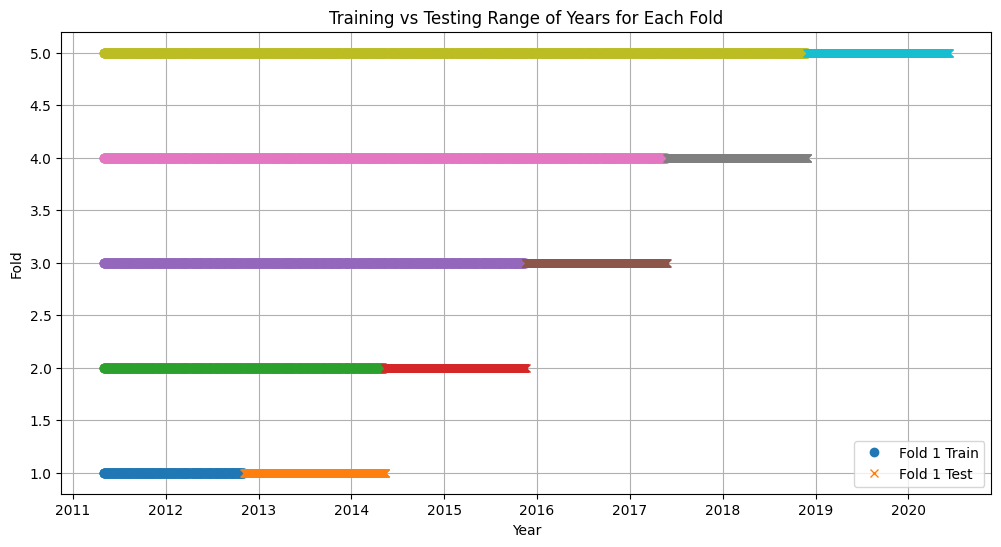

In [16]:
# Plot training vs testing years
plt.figure(figsize=(12, 6))

for i, (train, test) in enumerate(zip(train_years, test_years)):
    plt.plot(train, [i + 1] * len(train), 'o', label=f'Fold {i + 1} Train' if i == 0 else "")
    plt.plot(test, [i + 1] * len(test), 'x', label=f'Fold {i + 1} Test' if i == 0 else "")

plt.xlabel('Year')
plt.ylabel('Fold')
plt.title('Training vs Testing Range of Years for Each Fold')
plt.legend(loc='lower right')
plt.grid()
plt.show()


# Model training and evaluation



Fold 1 Confusion Matrix:
[[141  17]
 [100 124]]


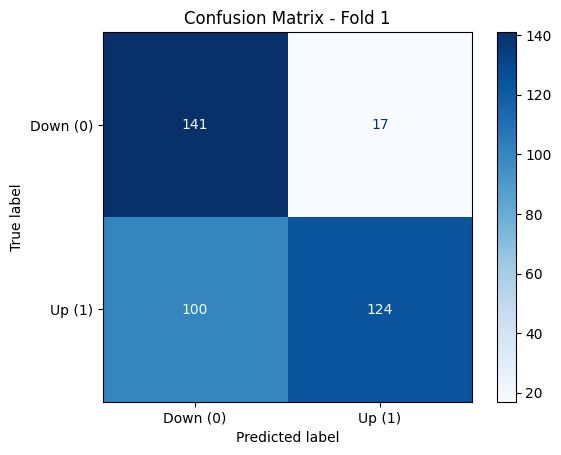

Fold 1 Accuracy: 0.69
--------------------------------------------------

Fold 2 Confusion Matrix:
[[  9 168]
 [  0 205]]


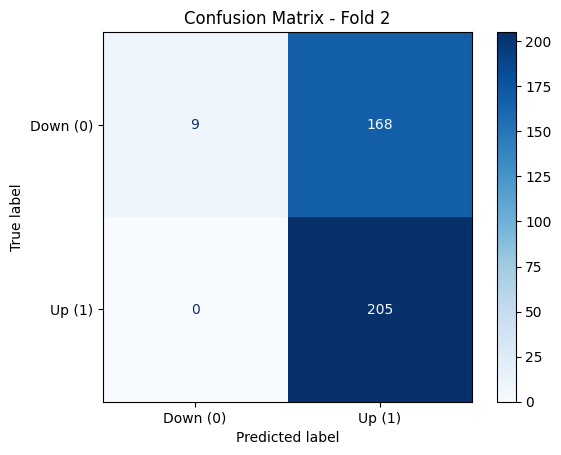

Fold 2 Accuracy: 0.56
--------------------------------------------------

Fold 3 Confusion Matrix:
[[ 57  98]
 [  1 226]]


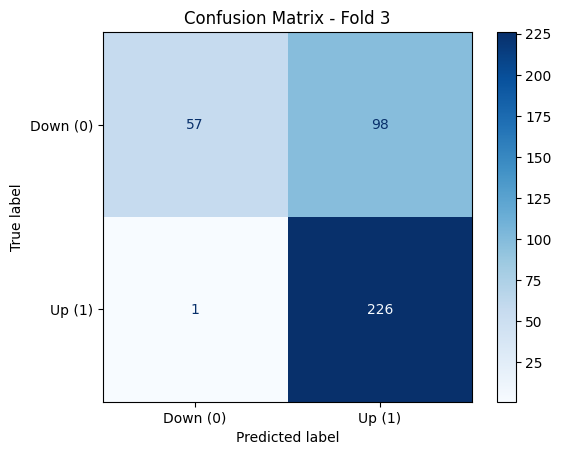

Fold 3 Accuracy: 0.74
--------------------------------------------------

Fold 4 Confusion Matrix:
[[ 62 112]
 [  0 208]]


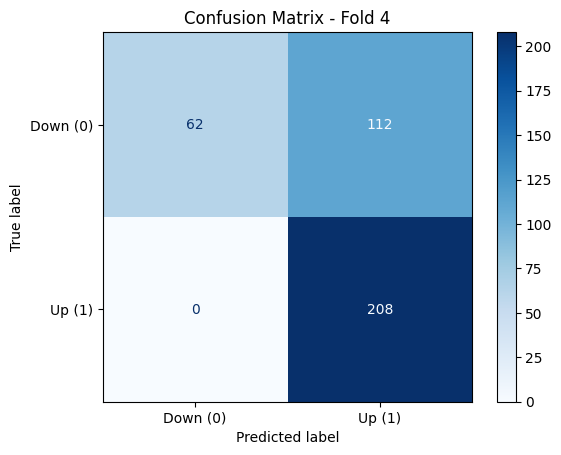

Fold 4 Accuracy: 0.71
--------------------------------------------------

Fold 5 Confusion Matrix:
[[115  50]
 [  1 216]]


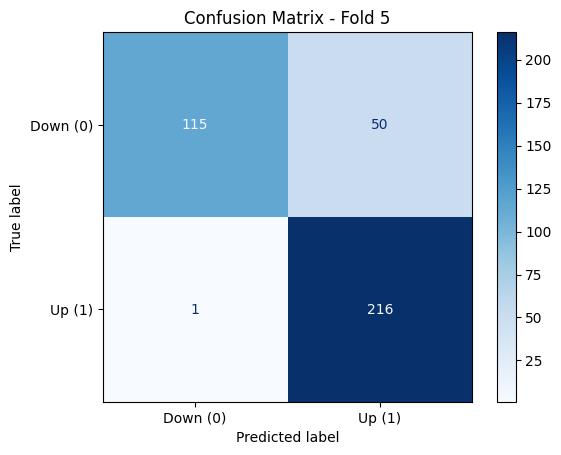

Fold 5 Accuracy: 0.87
--------------------------------------------------

Average Metrics Across Folds:
Accuracy: 0.71
Precision: 0.72
Recall: 0.91
F1-Score: 0.78
ROC-AUC: 0.87


In [17]:
# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize and train the Logistic Regression model
    model = LogisticRegression(random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Append metrics for each fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)
    
    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nFold {fold + 1} Confusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down (0)", "Up (1)"])
    disp.plot(cmap="Blues")
    disp.ax_.set_title(f"Confusion Matrix - Fold {fold + 1}")
    plt.show()
    
    # Print accuracy for the fold
    print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}")
    print("-" * 50)

# Print average metrics
print("\nAverage Metrics Across Folds:")
print(f"Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}")
print(f"Precision: {sum(precision_scores) / len(precision_scores):.2f}")
print(f"Recall: {sum(recall_scores) / len(recall_scores):.2f}")
print(f"F1-Score: {sum(f1_scores) / len(f1_scores):.2f}")
print(f"ROC-AUC: {sum(roc_auc_scores) / len(roc_auc_scores):.2f}")


# Evaluation on balanced data

Fold 1 - Balanced Class Distribution:
Movement
0    187
1    187
Name: count, dtype: int64
--------------------------------------------------

Fold 1 Confusion Matrix:
[[145  13]
 [115 109]]


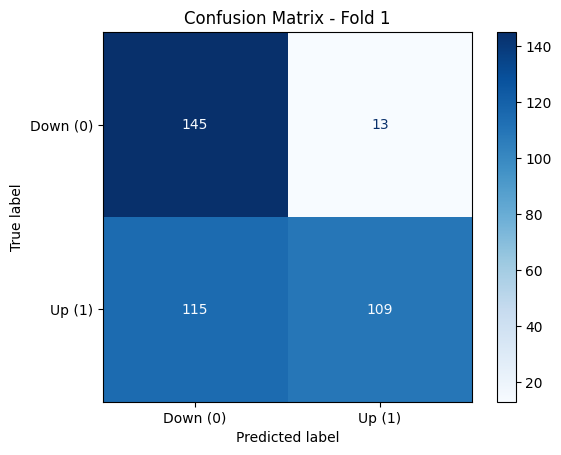

Fold 1 Accuracy: 0.66
--------------------------------------------------
Fold 2 - Balanced Class Distribution:
Movement
0    345
1    345
Name: count, dtype: int64
--------------------------------------------------

Fold 2 Confusion Matrix:
[[ 35 142]
 [  3 202]]


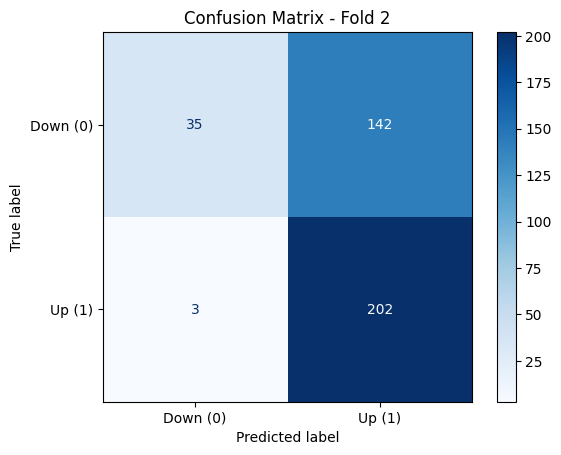

Fold 2 Accuracy: 0.62
--------------------------------------------------
Fold 3 - Balanced Class Distribution:
Movement
0    522
1    522
Name: count, dtype: int64
--------------------------------------------------

Fold 3 Confusion Matrix:
[[127  28]
 [ 90 137]]


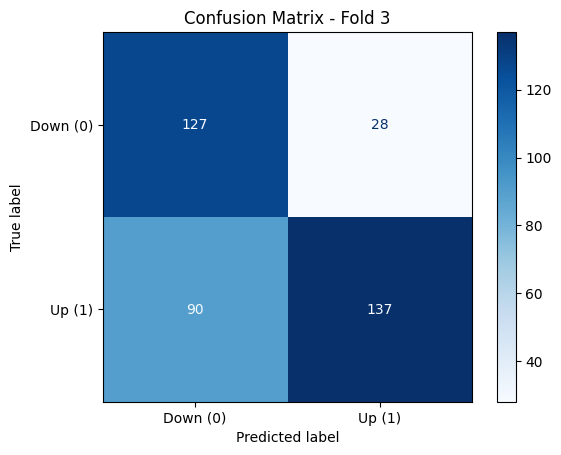

Fold 3 Accuracy: 0.69
--------------------------------------------------
Fold 4 - Balanced Class Distribution:
Movement
0    677
1    677
Name: count, dtype: int64
--------------------------------------------------

Fold 4 Confusion Matrix:
[[ 98  76]
 [  3 205]]


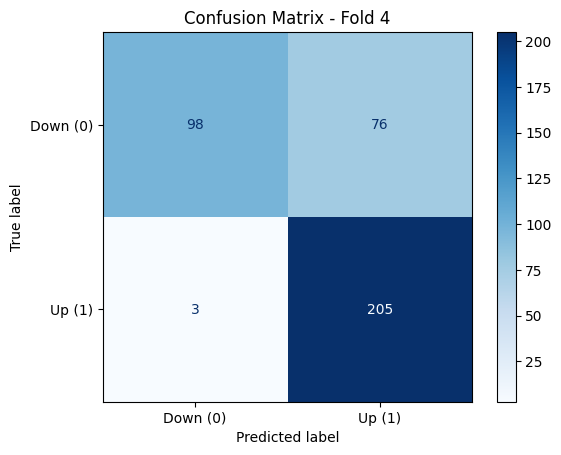

Fold 4 Accuracy: 0.79
--------------------------------------------------
Fold 5 - Balanced Class Distribution:
Movement
0    851
1    851
Name: count, dtype: int64
--------------------------------------------------

Fold 5 Confusion Matrix:
[[158   7]
 [ 27 190]]


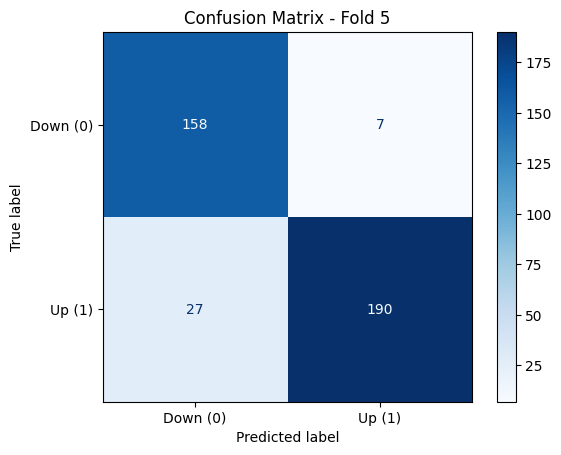

Fold 5 Accuracy: 0.91
--------------------------------------------------

Average Metrics Across Folds (Balanced Data):
Accuracy: 0.74
Precision: 0.80
Recall: 0.79
F1-Score: 0.76
ROC-AUC: 0.86


In [18]:
# Initialize SMOTE for balancing the dataset
undersampler = RandomUnderSampler(random_state=42)

# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Balance the training data
    X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)
    
    # Print class distribution for the balanced training data
    print(f"Fold {fold + 1} - Balanced Class Distribution:")
    print(y_train_balanced.value_counts())
    print("-" * 50)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize and train the Logistic Regression model
    model = LogisticRegression(random_state=42)
    model.fit(X_train_scaled, y_train_balanced)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Append metrics for each fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)
    
    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nFold {fold + 1} Confusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down (0)", "Up (1)"])
    disp.plot(cmap="Blues")
    disp.ax_.set_title(f"Confusion Matrix - Fold {fold + 1}")
    plt.show()

    # Print accuracy for the fold
    print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}")
    print("-" * 50)


# Print average metrics
print("\nAverage Metrics Across Folds (Balanced Data):")
print(f"Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}")
print(f"Precision: {sum(precision_scores) / len(precision_scores):.2f}")
print(f"Recall: {sum(recall_scores) / len(recall_scores):.2f}")
print(f"F1-Score: {sum(f1_scores) / len(f1_scores):.2f}")
print(f"ROC-AUC: {sum(roc_auc_scores) / len(roc_auc_scores):.2f}")


In [19]:
data.to_csv('../../../dataset_final/Daily_Financial_News/MU/MU_numerical_LR.csv')